In [12]:
import os
import random
from utils.snowflake_funcs import snowflake_connector  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import warnings

## Load data

In [ ]:
# load data from database by SQL

## Allocate data into strata

In [7]:
q1 = data['NUM_GAME_START'].quantile(0.25)
q2 = data['NUM_GAME_START'].quantile(0.5)
q3 = data['NUM_GAME_START'].quantile(0.75)

In [18]:
print(q1, q2, q3)

1.0 4.0 20.0


In [ ]:
# create a list of our conditions
conditions = [
    (data['NUM_GAME_START'] <= q1),
    (data['NUM_GAME_START'] > q1) & (data['NUM_GAME_START'] <= q2),
    (data['NUM_GAME_START'] > q2) & (data['NUM_GAME_START'] <= q3),
    (data['NUM_GAME_START'] > q3)
    ]

# create a list of the values we want to assign for each condition
strata = [1,2,3,4]

# create a new column and use np.select to assign values to it using our lists as arguments
data['STRATA'] = np.select(conditions, strata)

# display updated DataFrame
data.head()

## Functions: caculate meandiff and strata meandiff

In [9]:
def weighted_mean(df, weight_col='weight'):
    return np.average(df['NUM_GAME_START'], weights=df[weight_col])

In [10]:
def strata_meandiff(treatment, control):
    total_weight = 0
    weighted_diff_sum = 0
    for stratum in data['STRATA'].unique():
        # Calculate stratum sizes
        stratum_size = data[data['STRATA'] == stratum].shape[0]
        treatment_stratum = treatment[treatment['STRATA'] == stratum]
        control_stratum = control[control['STRATA'] == stratum]
        # Assign weights based on the proportion of the stratum in the overall sample
        treatment_stratum['weight'] = stratum_size / len(treatment_stratum)
        control_stratum['weight'] = stratum_size / len(control_stratum)
        # Calculate weighted mean differences
        treatment_mean = weighted_mean(treatment_stratum)
        control_mean = weighted_mean(control_stratum)
        weighted_diff_sum += (treatment_mean - control_mean) * stratum_size
        total_weight += stratum_size
    return weighted_diff_sum / total_weight

## A/A test

In [ ]:
game_start_difference_post_strata = []
warnings.filterwarnings('ignore')
for i in range(1000):

    print(i)
    # split data to treatment and control groups randomly
    treatment, control = train_test_split(data, test_size=0.5, shuffle=True)

    # calculate the weighted meandiff 
    strata_mean_difference = strata_meandiff(treatment, control)

    # store the difference
    game_start_difference_post_strata.append(strata_mean_difference)


game_start_difference_post_strata

## Result visualisation

<Axes: ylabel='Density'>

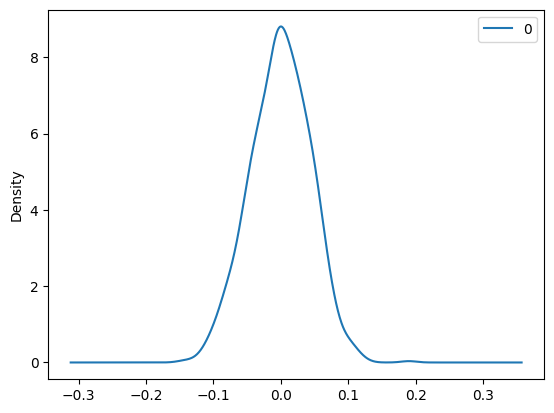

In [14]:
df_game_start_difference_post_strata = pd.DataFrame(game_start_difference_post_strata,dtype=float)
df_game_start_difference_post_strata.plot.kde()

Text(0, 0.5, 'Density')

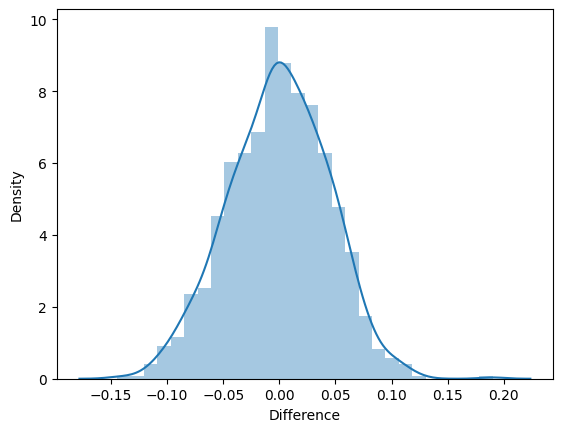

In [17]:
sns.distplot(df_game_start_difference_post_strata)
plt.xlabel('Difference')
plt.ylabel('Density')
# plt.title('Distribution of Differences Between Variants in the A/A Test with Post-stratification')

In [15]:
df_game_start_difference_post_strata.to_pickle('result/model2.pkl')